In [486]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import random, os, pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import lstsq
%matplotlib inline

In [2]:
save_dir = os.path.join('../save2/')

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
input_shape = (32, 32, 3)
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [4]:
def set_up_model():
    inputs = Input(shape=input_shape)
    x = Conv2D(4, kernel_size=(7,7), strides=(1, 1), activation='relu', padding='same')(inputs)
    x = Conv2D(4, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = Conv2D(8, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(x)
    x = Conv2D(8, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = Conv2D(16, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(x)
    x = Conv2D(16, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(10, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

In [5]:
models = []
for i in range(21):
    model = set_up_model()
    model.load_weights(os.path.join(save_dir, 'weights_%d'%i))
    models.append(model)

In [6]:
histories = []
for i in range(21):
    with open(os.path.join(save_dir, 'history_%d'%i), 'rb') as f:
        history = pickle.load(f)
    histories.append(history)

# Validation accuracy during training

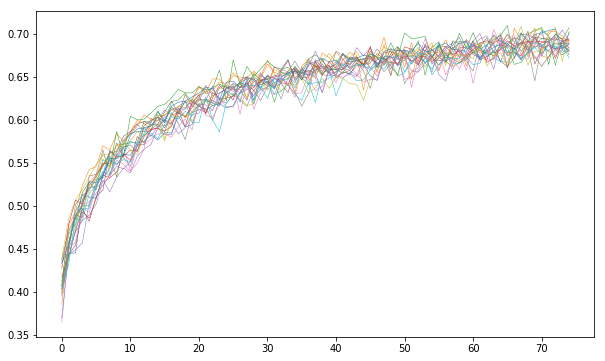

In [494]:
plt.gcf().set_size_inches([10,6])
for hist in histories:
    plt.plot(hist['val_acc'], lw=0.5)

# Highest achieved validation accuracy

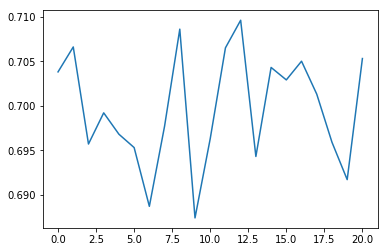

In [8]:
plt.plot([max(hist['val_acc']) for hist in histories])

In [9]:
first_filters = np.array([model.get_weights()[0] for model in models])

(height, width, channels_in, channels_out)

In [10]:
first_filters.shape

(21, 7, 7, 3, 4)

In [386]:
def scale_filter(arr, flip=False):
    if flip: 
        arr = arr*-1
    arr = arr - arr.min()
    arr /= arr.max()
    return arr

# View filters, scaled to [0, 1] (not channel-wise)

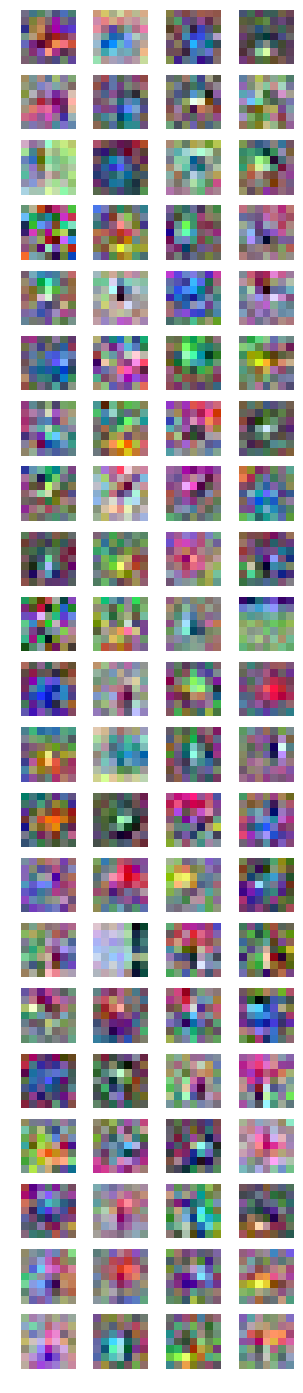

In [363]:
fig, ax = plt.subplots(ncols=4, nrows=21, figsize=[5,25])
for i in range(21):
    for j in range(4):
        ax[i, j].axis('off')
        ax[i, j].imshow(scale_filter(first_filters[i, :, :, :, j]))

In [172]:
def unit_sphere(v):
    return v / np.sqrt((v**2).sum())

Flatten filters and rescale to unity, for each network instance compute dot product between the four first filters

In [173]:
flat_unit_filters = np.array([[unit_sphere(first_filters[i, :, :, :, j].flatten()) for j in range(4)] for i in range(21)])

In [178]:
dotprods = np.zeros([21, 4, 4])
for i in range(21):
    for j in range(4):
        for k in range(4):
            dotprods[i, j, k] = np.dot(flat_unit_filters[i, j], flat_unit_filters[i, k])

Get rid of lower half + diagonal

In [520]:
triu = ~np.tri(4, dtype=np.bool)
vtriu = np.stack([triu]*21)

In [521]:
triu_dots = []
for i in range(21):
    triu_dots.append(dotprods[i][triu])
triu_dots = np.array(triu_dots)

In [522]:
dotprods[vtriu].shape

(126,)

In [523]:
print(np.abs(triu_dots).mean(), '\n')
print(np.abs(triu_dots).min(axis=-1), '\n')
print(np.abs(triu_dots).max(axis=-1))

0.12263729022298422 

[0.01395917 0.0159713  0.00507772 0.01455796 0.00268024 0.0203686
 0.0293407  0.00658586 0.05943044 0.00228206 0.02294826 0.01951028
 0.01652855 0.01421643 0.01162887 0.02977121 0.01059032 0.08813189
 0.02130195 0.05245214 0.01084855] 

[0.28443941 0.18487304 0.12704484 0.18750876 0.40125209 0.29481328
 0.31590813 0.29697838 0.26709321 0.22743063 0.18303837 0.30749404
 0.22035065 0.25143692 0.41623569 0.23219855 0.07708436 0.27022532
 0.20442419 0.24031837 0.21008556]


Find two networks with most orthogonal filters

In [379]:
np.argsort(np.abs(triu_dots).mean(axis=-1))[:2]

array([16,  2])

In [380]:
np.abs(triu_dots[[16, 2]])

array([[0.06990987, 0.07708436, 0.05461196, 0.01059032, 0.07332336,
        0.02812371],
       [0.02786441, 0.04388678, 0.12704484, 0.09573111, 0.04643278,
        0.00507772]])

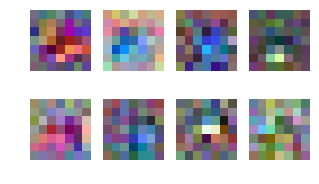

In [390]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=[5, 3])
for i, index in enumerate([16, 2]):
    for j in range(4):
        ax[i, j].imshow(scale_filter(first_filters[i, :, :, :, j]))
        ax[i, j].axis('off')

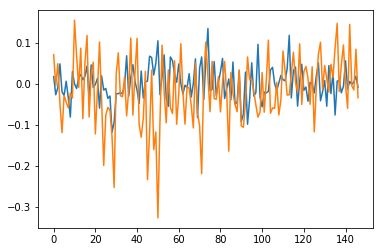

In [531]:
basis = flat_unit_filters[15]
res = lsq_linear(basis.T, flat_unit_filters[2][1].T)
plt.plot(np.matmul(basis.T, res.x))
plt.plot(flat_unit_filters[2][0])

In [532]:
res

 active_mask: array([0., 0., 0., 0.])
        cost: 0.3667732775211334
         fun: array([-1.60880312e-01, -1.85643453e-02, -5.59816808e-02, -2.31519192e-02,
       -1.50246173e-02, -1.36093237e-03, -3.15365307e-02,  2.23884732e-02,
       -1.05787233e-01, -1.80959702e-04,  1.28502786e-01, -1.12011377e-02,
        5.85854705e-03,  1.34954587e-01,  3.85935344e-02, -1.32777572e-01,
        1.54438168e-01,  2.30789706e-02, -1.42110169e-01,  5.36710676e-03,
        9.12140533e-02,  6.04403429e-02,  2.59712785e-02, -1.28414333e-02,
        5.88435903e-02,  1.18177332e-01, -1.03778318e-01,  4.29738276e-02,
       -8.61523822e-02, -4.66412492e-02, -2.74334121e-02,  5.26500605e-02,
       -5.66750132e-02, -6.92115650e-02,  1.66271076e-01,  1.74813688e-01,
       -1.05118960e-01,  4.35443223e-02,  2.97237337e-02, -3.47316358e-03,
        2.40241848e-02,  2.01383084e-02, -3.72864157e-02, -2.86373347e-02,
       -1.00477599e-03,  1.02359802e-01,  5.45183793e-02,  3.77728269e-02,
        1.66761

Compute errors for all network combinations

In [466]:
mean_relative_errors = np.zeros([21, 21, 4])

In [537]:
for i in range(21):
    basis = flat_unit_filters[i].T
    for j in range(21):
        sim_filters = flat_unit_filters[j]
        for l in range(4):
            x, res, rank, s = lstsq(basis, sim_filters[l].T)
            mean_relative_errors[i, j, l] = np.abs((np.matmul(basis, x) - sim_filters[l]) / sim_filters[l]).mean()

In [512]:
triu = np.stack([~np.tri(21, dtype=np.bool)]*4).transpose([2,1,0])
print(mean_relative_errors[triu].mean())
print(mean_relative_errors[triu].min())
print(mean_relative_errors[triu].max())

2.49671032613232
1.0305933952331543
33.3581428527832
